In [1]:
import numpy as np
print("numpy version: {}".format(np.__version__))
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()
import time
from scipy.stats import norm
import numexpr
numexpr.print_versions()

numpy version: 1.17.2
Networkx version: 2.4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.7.0
NumPy version:     1.17.2
Python version:    3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Mon Sep 16 14:19:51 EDT 2019
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 64 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")


import os
#print(os.environ['HOME'])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

2.0.0
Using a GPU


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

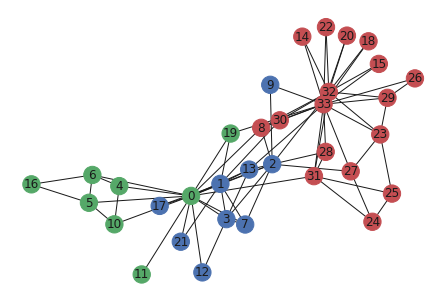

In [5]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
G = nx.karate_club_graph()
c = list(greedy_modularity_communities(G))
# show first 5 graphs
pos = nx.spring_layout(G)
colors = np.array(['r', 'b', 'g'])
label = np.arange(0,len(G))
label[list(c[0])] = 0
label[list(c[1])] = 1
label[list(c[2])] = 2
nx.draw(G, node_color=colors[label], with_labels=True, pos=pos)
plt.show()
plt.close()

In [6]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_prob(G, k, weighted=False, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = len(G)
    a = tf.ones(k) #number of blocks
    pi = ed.Dirichlet(concentration=a, name="pi") #prior for block assignments  
    z = ed.Categorical(probs=pi, name="z",sample_shape=n) #block labels
    #if weighted:
    #    eta = ed.Gamma(concentration=0.001, rate=0.001, name="eta", sample_shape=[k,k]) #gamma prior for weighted edges
    #else:
    eta = ed.Beta(concentration1=1, concentration0=1, name="eta", sample_shape=[k,k]) #beta prior for simple edges
    # parameters to sample the adjacency matrix
    # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
    # very inefficient parameterization
    tile_a = tf.tile(tf.expand_dims(z, 1), [1, tf.shape(z)[0]])  
    tile_a = tf.expand_dims(tile_a, 2) 
    tile_b = tf.tile(tf.expand_dims(z, 0), [tf.shape(z)[0], 1]) 
    tile_b = tf.expand_dims(tile_b, 2)
    p = tf.gather_nd(eta, tf.concat([tile_a, tile_b], axis=2))
    #if not selfloops:
    #    TT.set_subtensor(p[np.diag_indices(n)], 0.)
    #if not directed:
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    A = ed.Bernoulli(name = 'A', probs=p)
    return A

In [7]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_prob_fast(G, k, weighted=False, directed=False, selfloops=False):
    # 
    n = len(G)
    A_obs = tf.convert_to_tensor(nx.to_numpy_array(G), dtype=tf.float32)
    
    
    # the SBM log-likelihood generative steps
    a = tf.ones(k) #number of blocks
    pi = ed.Dirichlet(concentration=a, name="pi") #prior for block assignments  
    z = ed.Categorical(probs=pi, name="z",sample_shape=n) #block labels
    if weighted:
        eta = ed.Gamma(concentration=0.001, rate=0.001, name="eta", sample_shape=[k,k]) #gamma prior for weighted edges
    else:
        eta = ed.Beta(concentration1=1, concentration0=1, name="eta", sample_shape=[k,k]) #beta prior for simple edges
    #if not selfloops:
    #    tt.set_subtensor(p[np.diag_indices(n)], 0.)
    #if not directed:
    
    # Collect block-pairwise edge/non-edge sufficient statistics for the analytical posterior
    # Weighted(counting) version to be updated
    m_obs = tf.zeros([k,k])
    for i in range(n):
        for j in range(i+1, n):
            cumulate_value_at_position(z[i], z[j], nx.to_numpy_array(G)[i,j])
    
    # Original p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    # replace the n*n adjacency matrix p with the k*k affinity matrix m
    if weighted:
        m = ed.Gamma(name = 'm', alpha=.001, beta=.001, shape=(k, k)) #replace with equation 5.5 for analytical posterior, including DC?
    else:
        for i in range(k):
            for j in range(k):
                m = ed.Beta(name = 'm_{i}_{j}', alpha=1, beta=1, shape=(k, k), observed=cumulator[i,j])
    if weighted:
        logP = ed.Poisson(name='A', probs=p) #manual analytical posterior vs ed.make_log_joint_fn()
    return logP

In [239]:
tf.zeros([k,k])

<tf.Tensor: id=11024, shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [233]:
from tensorflow_probability import edward2 as ed
a = np.ones(k)
pi = ed.Dirichlet(concentration=a, name="pi")
z = ed.Categorical(probs=pi, name="z",sample_shape=n)
eta = ed.Beta(concentration1=1, concentration0=1, name="eta", sample_shape=[k,k])
#tf.gather_nd(eta, tf.stack((tf.reshape(z, [8, 1]), tf.reshape(z, [8, 1])),-1))
z

<ed.RandomVariable 'z' shape=(34,) dtype=int32 numpy=
array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [227]:
tile_a = tf.tile(tf.expand_dims(z, 1), [1, tf.shape(z)[0]])  
tile_a = tf.expand_dims(tile_a, k) 
tile_b = tf.tile(tf.expand_dims(z, 0), [tf.shape(z)[0], 1]) 
tile_b = tf.expand_dims(tile_b, k)
p = tf.gather_nd(eta, tf.concat([tile_a, tile_b], axis=2))
ed.Bernoulli(name = 'A', probs=p)

<ed.RandomVariable 'A' shape=(34, 34) dtype=int32 numpy=
array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [264]:
log_joint = ed.make_log_joint_fn(SBM_prob)
# Function to compute the log posterior probability
n = len(G)
k = 2
A_obs = tf.convert_to_tensor(nx.to_numpy_array(G), dtype=tf.float32)
def target_log_prob_fn(pi, eta):
  return log_joint(
      G = G,
      k = k,
      pi = pi,
      z = z,
      eta = eta,
      A=A_obs)

# set initial state (drawn from prior)
ppi = tf.random.uniform([k], minval=0, maxval=1, dtype=tf.float32) #number of blocks
#pz = tf.squeeze(tf.random.categorical(tf.math.log([[0.5, 0.5]]), n))
peta = tf.random.uniform([k,k], minval=0, maxval=1, dtype=tf.float32)
print(target_log_prob_fn(ppi, peta)) #test the target_log_prob_fn with initial state

tf.Tensor(-1331.7339, shape=(), dtype=float32)


In [341]:
Nsamples = 20000  # final number of samples
Nburn = 20000     # number of tuning samples

# set up Hamiltonian MC
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.01,
    num_leapfrog_steps=5)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=Nsamples,
    num_burnin_steps=Nburn,
    current_state=[ppi, peta],
    trace_fn=(lambda current_state, kernel_results: kernel_results),
    parallel_iterations=100,
    kernel=hmc_kernel)

kernel_results.is_accepted.numpy().mean()

0.9226

In [301]:
results = dict(zip(['pi', 'eta'], states))
print(results['pi'].shape)
print(results['eta'].shape)

(2000, 2)
(2000, 2, 2)


In [344]:
results

{'pi': <tf.Tensor: id=30696373, shape=(2000, 2), dtype=float32, numpy=
 array([[0.68113065, 4.7236953 ],
        [0.74135053, 4.8108263 ],
        [0.7586747 , 4.8571563 ],
        ...,
        [1.5269258 , 5.2762933 ],
        [1.5484931 , 5.2039833 ],
        [1.5868136 , 5.140377  ]], dtype=float32)>,
 'eta': <tf.Tensor: id=30696374, shape=(2000, 2, 2), dtype=float32, numpy=
 array([[[0.15730068, 0.2124092 ],
         [0.17063251, 0.1263656 ]],
 
        [[0.07627922, 0.16696472],
         [0.18719272, 0.12052315]],
 
        [[0.09959515, 0.13607574],
         [0.187124  , 0.12291322]],
 
        ...,
 
        [[0.05789775, 0.15939867],
         [0.15319832, 0.1357354 ]],
 
        [[0.09502731, 0.16638221],
         [0.1268637 , 0.1084962 ]],
 
        [[0.09040114, 0.19293846],
         [0.20453364, 0.13648903]]], dtype=float32)>}

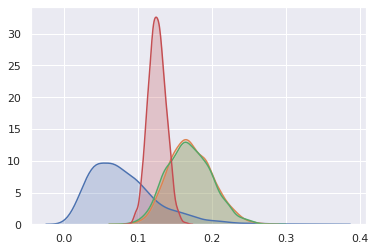

In [354]:
sns.kdeplot(results['eta'][:,0,0].numpy(),shade=True)
sns.kdeplot(results['eta'][:,0,1].numpy(),shade=True)
sns.kdeplot(results['eta'][:,1,0].numpy(),shade=True)
sns.kdeplot(results['eta'][:,1,1].numpy(),shade=True)

In [333]:
def trace_plot(data, title='', ax=None):
    #Plot both chain and posterior distribution'''
    if ax is None:
        ax = plt.gca()
    ax.plot(data)
    ax.title.set_text(title+" trace_plot")
    
def post_plot(data, title='', ax=None, true=None, prc=95):
    #Plot the posterior distribution given MCMC samples'''
    if ax is None:
        ax = plt.gca()
    sns.kdeplot(data.numpy(), ax=ax, shade=True)
    tprc = (100-prc)/2
    ax.axvline(x=np.percentile(data, tprc), linestyle='--')
    ax.axvline(x=np.percentile(data, 100-tprc), linestyle='--')
    ax.title.set_text(title+" distribution")
    if true is not None:
        ax.axvline(x=true)
    
def trace_post_plot(data, title='', ax=None, true=None):
    #Plot a chain of MCMC samples'''
    trace_plot(data, title=title, ax=ax[0])
    post_plot(data, title=title, ax=ax[1], true=true)

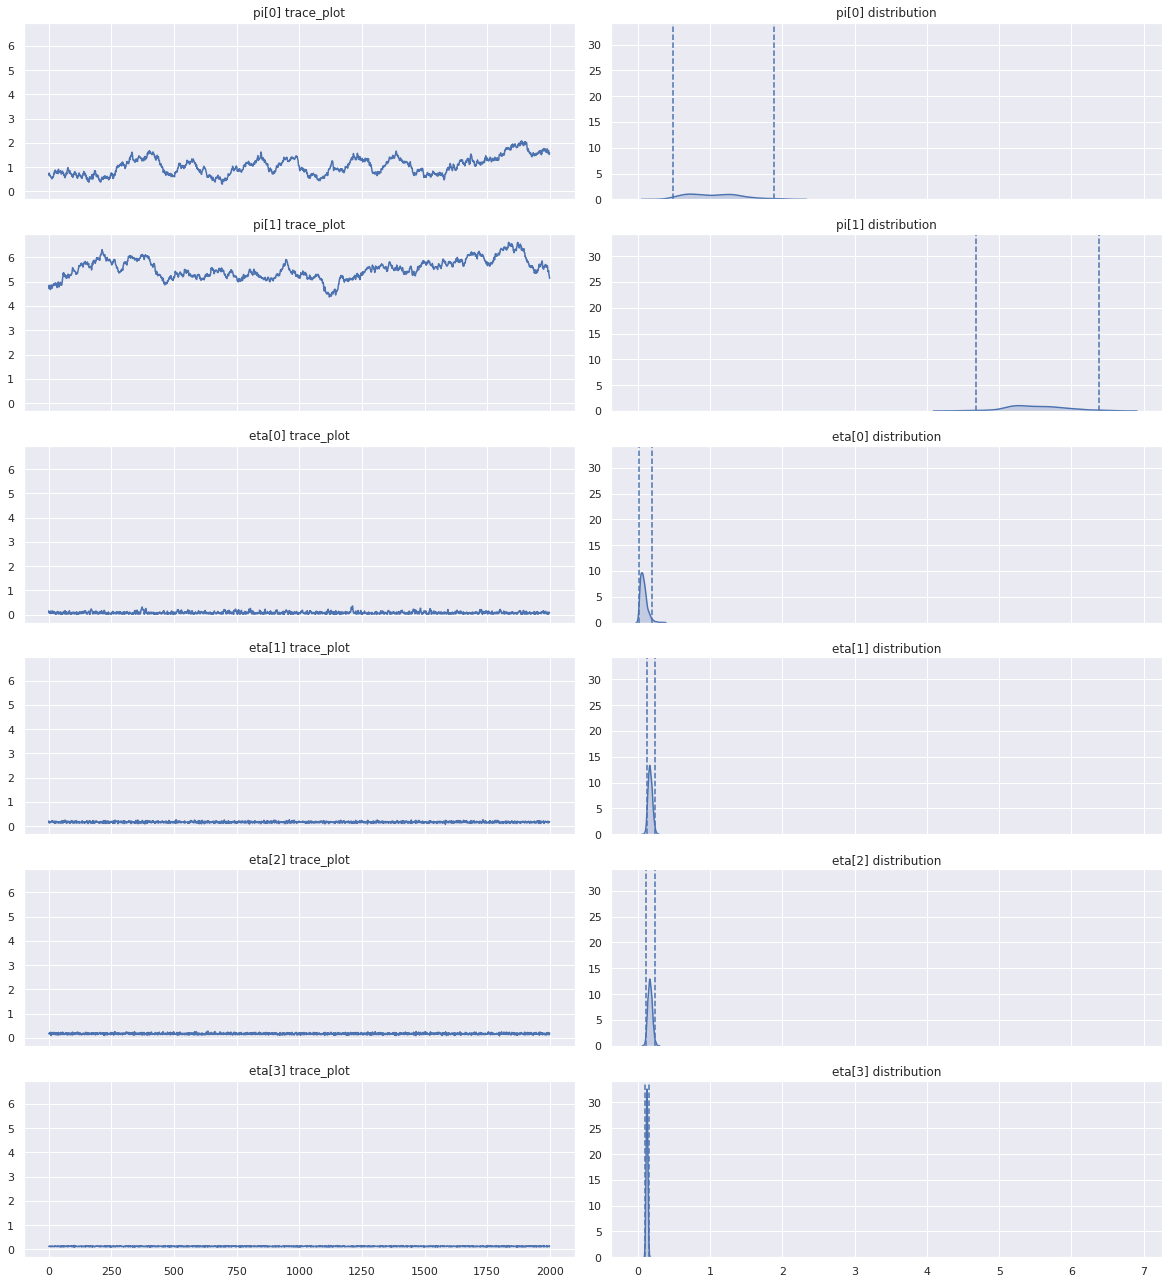

In [352]:
# Plot trace and distributions for coefficients
fig, axes = plt.subplots(k+k*k, 2, sharex='col', sharey='col')
fig.set_size_inches(16.4, 18)
for i in range(k):
    trace_post_plot(results['pi'][:,i], title="pi[{}]".format(i), ax=axes[i])

for i in range(k):
    for j in range(k):
        trace_post_plot(results['eta'][:,i,j], title="eta[{}]".format(i*k+j), ax=axes[2+i*k+j])

fig.tight_layout()
plt.show()

In [326]:
axes[2][1]

In [ ]:
def updateDAG(G, NodeMerge):
    size = len(NodeMerge);
    u,v = NodeMerge[0]
    for i in range (0,size):
        print(NodeMerge[i])
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        B = np.vstack([A, (A[nodes[0],:]+A[nodes[1],:])/2])
        A = np.column_stack([B, (B[:,nodes[0]]+B[:,nodes[1]])/2])
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    H = nx.from_numpy_matrix(A)
    H.remove_node(u)
    H.remove_node(v)
    #print(H.node())
    return H

In [ ]:
def getCandidates(G, labels):
    A = nx.adjacency_matrix(G).todense()
    np.fill_diagonal(A, 9999)
    am = A.argmin() #find min pair
    c0 = am % A.shape[1]
    r0 = am // A.shape[1]
    A[c0,r0] = 9999
    A[r0,c0] = 9999
    c1 = A[r0,:].argmin() #find 2nd min pair
    r1 = A[:,c0].argmin() #find 2nd min pair
    
    Llist = []    
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c0]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[c0] = labelsNew[r1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    return Llist

In [ ]:
def buildLayer(G, k, Llist):
    Mlist = []
    Tlist = []

    for iteration in range (0,3):
        labels = Llist[iteration]
        model = make_pymc3_sbm(G, k, labels)
        with model as modelX:
            trace = pm.sample(1500, tune = 500)
        Mlist.append(modelX)
        Tlist.append(trace)

    Mlist[0].name = '0'
    Mlist[1].name = '1'
    Mlist[2].name = '2'
    comp = pm.compare({Mlist[0]: Tlist[0], Mlist[1]: Tlist[1], Mlist[2]: Tlist[2]}, method='BB-pseudo-BMA')
    #print(comp.weight)
    return comp.weight

In [ ]:
from collections import Counter

label = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Gnew = G
while True:
    k = len(Gnew)
    label = np.arange(k)
    Llist = getCandidates(Gnew,label)
    ModelPosterior = buildLayer(Gnew, k-1, Llist)
    thresh = ModelPosterior['0'] + 0.3 #use the closest pair as the posterior threshold, increase to speed up convergence
    newInternal = ModelPosterior[ModelPosterior  > thresh].index.astype(int)
    NodeMerge = [] #nodes to be merged, closest pair added as the defult
    dup = [item for item, count in Counter(Llist[0]).items() if count > 1]
    nodes = np.where(Llist[0] == dup[0])
    NodeMerge.append(nodes[0])
    print(Llist[0])
    for i in range (0,len(newInternal)):
        newLabel = Llist[newInternal[i]]
        print(newLabel)
        dup = [item for item, count in Counter(newLabel).items() if count > 1]
        nodes = np.where(newLabel == dup[0])
        NodeMerge.append(nodes[0])
    Gnew = updateDAG(Gnew, NodeMerge) #update the graph with node mergers/splits
    if k<=3:
        break  